In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from transformers import  TFTrainingArguments
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import datetime

from keras.preprocessing import image
from keras.applications import resnet50

In [2]:
!unzip '/content/data_augmentation.zip'


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data_augmentation/FACE/1144.jpg_aug_169.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_17.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_18.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_19.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_2.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_20.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_21.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_22.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_23.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_24.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_25.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_26.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_27.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_28.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_29.jpg  
  inflating: data_augmentation/FACE/1144.jpg_aug_3.j

In [3]:
base_path ='/content/data_augmentation'

In [4]:
batch_size = 32
img_height = 224
img_width = 224

train = tf.keras.utils.image_dataset_from_directory(
  base_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val = tf.keras.utils.image_dataset_from_directory(
  base_path,
  validation_split=0.2,
  subset="validation",
  seed=123,

  image_size=(img_height, img_width),
  batch_size=batch_size
)

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train.map(lambda x, y: (normalization_layer(x), y))
val_ds = val.map(lambda x, y: (normalization_layer(x), y))
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Found 8690 files belonging to 49 classes.
Using 6952 files for training.
Found 8690 files belonging to 49 classes.
Using 1738 files for validation.
(32, 224, 224, 3)
(32,)


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense



def create_model(num_classes):
    base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)


    return model


In [6]:
import numpy as np

class_names = np.array(train.class_names)
print(class_names)

['1.5_1_CAMELIA._5_ALLURES' '1932_COLLECTION_(2022)' 'BATH_AND_BODY'
 'BELTS' 'BLUE_LIGHT_GLASSES' 'BODY' 'BOY_DE_CHANEL' 'BRACELETS'
 'BROOCHES' 'BRUSHES_AND_ACCESSORIES' 'CAMELLIAS'
 'CLEANSERS___MAKEUP_REMOVERS' 'COCO_CRUSH' 'COMETE' 'COSTUME_JEWELRY'
 'EARRINGS' 'EXCEPTIONAL_PIECES' 'EYEGLASSES' 'EYES' 'EYE___LIP_CARE'
 'FACE' 'HANDBAGS' 'HEADWEAR' "L'ESPRIT_DU_LION"
 'LES_INTEMPORELS_DE_CHANEL' 'LIPS' 'MASKS___EXFOLIATORS'
 'MASSAGE_ACCESSORIES' 'MEN' 'MISTS' 'MOISTURIZERS' 'NAILS' 'NECKLACES'
 'N_5' 'N_5_COLLECTION' 'OILS' 'OTHER_ACCESSORIES' 'READY_TO_WEAR' 'RINGS'
 'SCARVES' 'SERUMS' 'SETS' 'SHOES' 'SMALL_LEATHER_GOODS'
 'SOUS_LE_SIGNE_DU_LION_HJ' 'SUNGLASSES' 'TONERS___LOTIONS' 'WATCHES'
 'WOMEN']


In [7]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([36, 32,  6,  4, 35, 25,  4, 26, 18, 35, 24, 42, 48, 19, 34,  5, 46,
       17, 19, 20,  2, 29, 33, 35, 12, 28, 47, 41, 34, 34, 11, 31],
      dtype=int32)>

In [8]:
model = create_model(len(class_names))
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)

NUM_EPOCHS = 10
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[early_stopping,tensorboard_callback])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


218/218 ━━━━━━━━━━━━━━━━━━━━ 53s 184ms/step - acc: 0.0974 - loss: 3.6598 - val_acc: 0.2957 - val_loss: 2.5859
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 30s 136ms/step - acc: 0.3446 - loss: 2.3341 - val_acc: 0.5253 - val_loss: 1.7423
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - acc: 0.5148 - loss: 1.6742 - val_acc: 0.6076 - val_loss: 1.3521
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - acc: 0.6114 - loss: 1.3058 - val_acc: 0.6899 - val_loss: 1.0955
Epoch 5/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 40s 143ms/step - acc: 0.6887 - loss: 1.0615 - val_acc: 0.7054 - val_loss: 0.9538
Epoch 6/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 32s 147ms/step - acc: 0.7181 - loss: 0.9364 - val_acc: 0.7382 - val_loss: 0.8494
Epoch 7/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 41s 148ms/step - acc: 0.7565 - loss: 0.8141 - val_acc: 0.7768 - val_loss: 0.7517
Epoch 8/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - acc: 0.7804 - loss: 0.7260 - val_acc: 0.7394 - val_loss: 0.7660
Epoch 9/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 41s

In [9]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print(f"Test accuracy: {test_acc}")

55/55 - 5s - 83ms/step - acc: 0.8331 - loss: 0.5418
Test accuracy: 0.833141565322876


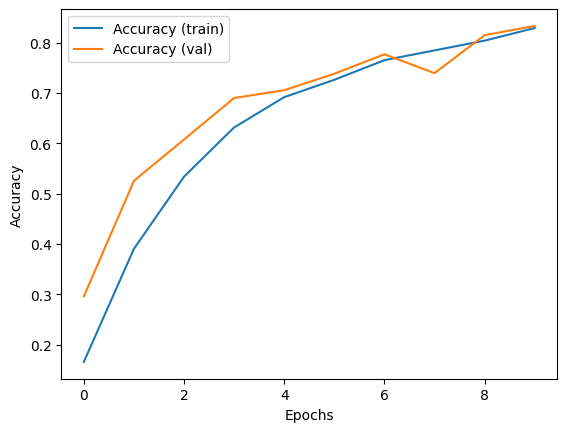

In [11]:
import matplotlib.pyplot as plt


plt.plot(history.history['acc'], label='Accuracy (train)')
plt.plot(history.history['val_acc'], label='Accuracy (val)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
embeddings =  model.predict(train_ds)
print("Embeddings shape:", embeddings)

218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step
Embeddings shape: [[1.6100626e-09 3.0597956e-08 2.7905857e-02 ... 1.4486089e-01
  1.0170786e-08 3.4804877e-08]
 [1.7241550e-21 2.1230167e-18 2.2365361e-17 ... 7.9877790e-15
  4.8776148e-09 1.5722973e-06]
 [1.8906222e-11 4.7213368e-07 1.3687368e-12 ... 3.5946921e-09
  2.0574785e-08 2.0966989e-04]
 ...
 [2.4510685e-10 7.2302784e-05 2.7022654e-05 ... 3.1814832e-02
  1.2522786e-12 3.3009688e-09]
 [4.5797147e-02 8.6424621e-03 1.8239075e-11 ... 1.5579740e-19
  2.3675930e-04 4.8666475e-06]
 [5.0459813e-11 6.7594885e-10 8.0879698e-07 ... 8.8564042e-07
  3.5582943e-09 3.4548297e-08]]


In [15]:
np.save('/content/ResNet_embeddings.npy', embeddings)


In [16]:
model.save('my_model_ResNet.keras')

In [22]:
import plotly.express as px
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd


def visualize_embeddings_tsne_plotly(embeddings, labels, class_names):
    if embeddings.ndim > 2:
        embeddings = embeddings.reshape(embeddings.shape[0], -1)

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_embeddings = tsne.fit_transform(embeddings)

    df = pd.DataFrame(reduced_embeddings, columns=['tsne_1', 'tsne_2'])
    df['label'] = labels
    df['class_name'] = df['label'].map(lambda x: class_names[x])

    fig = px.scatter(df, x='tsne_1', y='tsne_2', color='class_name',
                     hover_data=['class_name'],
                     title='t-SNE Embeddings Visualization with Plotly')

    fig.show()


labels = np.concatenate([y for x, y in train_ds], axis=0)

print("Embeddings shape before visualization:", embeddings.shape)
visualize_embeddings_tsne_plotly(embeddings, labels, class_names)

Embeddings shape before visualization: (6952, 49)


In [20]:
np.save('/content/ResNet_lables.npy', labels)
